# Day 4.1: Full Model Training

**Goal:** Train CNN model on the full combined enhanced dataset (7,181 images)

**What we'll do:**
1. Load train/val/test splits from Day 3
2. Configure data generators with augmentation
3. Build CNN model from Day 3
4. Set up training callbacks (EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
5. Train for up to 15 epochs
6. Save best model automatically
7. Visualize training history

**Expected time:** 20-30 minutes (with GPU) or 1-2 hours (with CPU)

**Expected accuracy:** 75-85% on validation set

---

**Dataset Info:**
- Train: 4,863 images (67.7%) from 346 patients
- Validation: 855 images (11.9%) from 62 patients
- Test: 1,463 images (20.4%) from 102 patients
- Classes: Meningioma, Glioma, Pituitary (3 classes)

---

## 1. Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from datetime import datetime

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✅ GPU available: {len(gpus)} GPU(s) detected")
    for gpu in gpus:
        print(f"   - {gpu}")
else:
    print("⚠️  No GPU detected - training will use CPU (slower but will work!)")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

2025-10-24 19:51:29.235240: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


TensorFlow version: 2.20.0
Keras version: 3.11.3
✅ GPU available: 1 GPU(s) detected
   - PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


## 2. Configuration

In [2]:
# Paths
TRAIN_CSV = "../../outputs/data_splits/train_split.csv"
VAL_CSV = "../../outputs/data_splits/val_split.csv"
TEST_CSV = "../../outputs/data_splits/test_split.csv"

# Create output directories
MODEL_DIR = "../../outputs/models"
HISTORY_DIR = "../../outputs/training_history"
VIZ_DIR = "../../outputs/visualizations"

os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(HISTORY_DIR, exist_ok=True)
os.makedirs(VIZ_DIR, exist_ok=True)

# Training hyperparameters
IMG_SIZE = (128, 128)
BATCH_SIZE = 32  # Reduce to 16 if you get GPU memory errors
EPOCHS = 15      # Maximum epochs (early stopping will likely stop earlier)
LEARNING_RATE = 0.001

# Class names
CLASS_NAMES = ['glioma', 'meningioma', 'pituitary']
NUM_CLASSES = len(CLASS_NAMES)

print("Configuration:")
print(f"  Image size: {IMG_SIZE}")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max epochs: {EPOCHS}")
print(f"  Learning rate: {LEARNING_RATE}")
print(f"  Classes: {CLASS_NAMES}")

Configuration:
  Image size: (128, 128)
  Batch size: 32
  Max epochs: 15
  Learning rate: 0.001
  Classes: ['glioma', 'meningioma', 'pituitary']


## 3. Load Data Splits

In [3]:
# Load CSV files
train_df = pd.read_csv(TRAIN_CSV)
val_df = pd.read_csv(VAL_CSV)
test_df = pd.read_csv(TEST_CSV)

# Ensure label column is string type (required by ImageDataGenerator)
train_df['label'] = train_df['label'].astype(str)
val_df['label'] = val_df['label'].astype(str)
test_df['label'] = test_df['label'].astype(str)

print("Data splits loaded:")
print(f"  Train: {len(train_df)} images from {train_df['patient_id'].nunique()} patients")
print(f"  Val:   {len(val_df)} images from {val_df['patient_id'].nunique()} patients")
print(f"  Test:  {len(test_df)} images from {test_df['patient_id'].nunique()} patients")
print(f"  Total: {len(train_df) + len(val_df) + len(test_df)} images")

# Show class distribution
print("\nClass distribution:")
print("Train:")
print(train_df['label'].value_counts())
print("\nValidation:")
print(val_df['label'].value_counts())
print("\nTest:")
print(test_df['label'].value_counts())

Data splits loaded:
  Train: 4863 images from 346 patients
  Val:   855 images from 62 patients
  Test:  1463 images from 102 patients
  Total: 7181 images

Class distribution:
Train:
label
2    1915
3    1616
1    1332
Name: count, dtype: int64

Validation:
label
2    321
3    276
1    258
Name: count, dtype: int64

Test:
label
2    511
3    495
1    457
Name: count, dtype: int64


## 4. Create Data Generators

**Training augmentation** (to prevent overfitting):
- Rotation: ±15°
- Width/Height shift: 5%
- Zoom: ±10%
- Horizontal flip: Yes

**Validation/Test:** No augmentation (just rescaling)

In [4]:
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and test generators (no augmentation)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=True,
    seed=42
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    color_mode='grayscale',
    shuffle=False
)

print("\nData generators created successfully!")
print(f"Steps per epoch: {len(train_generator)}")
print(f"Validation steps: {len(val_generator)}")

Found 4863 validated image filenames belonging to 3 classes.
Found 855 validated image filenames belonging to 3 classes.
Found 1463 validated image filenames belonging to 3 classes.

Data generators created successfully!
Steps per epoch: 152
Validation steps: 27


## 5. Build CNN Model

**Architecture:**
- Input: 128×128×1 grayscale images
- 3 Convolutional blocks (32, 64, 128 filters)
- BatchNormalization for stable training
- Dropout (0.5) to prevent overfitting
- Output: 3 classes (Softmax)

In [5]:
def build_cnn_model(input_shape=(128, 128, 1), num_classes=3):
    """
    Build CNN model for brain tumor classification.
    
    Args:
        input_shape: Shape of input images (height, width, channels)
        num_classes: Number of output classes
    
    Returns:
        Compiled Keras model
    """
    model = Sequential([
        # Block 1: 32 filters
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Block 2: 64 filters
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Block 3: 128 filters
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        # Dense layers
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        # Output layer
        Dense(num_classes, activation='softmax')
    ])
    
    return model

# Build model
model = build_cnn_model(input_shape=(128, 128, 1), num_classes=NUM_CLASSES)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
print("Model architecture:")
model.summary()

# Count parameters
total_params = model.count_params()
print(f"\nTotal parameters: {total_params:,}")

/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761315739.718282   35090 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2614 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 8,711,907 (33.23 MB)

 Trainable params: 8,710,243 (33.23 MB)

 Non-trainable params: 1,664 (6.50 KB)


Total parameters: 8,711,907


## 6. Configure Training Callbacks

**Callbacks explained:**
- **EarlyStopping:** Stops training if validation loss doesn't improve for 3 epochs
- **ModelCheckpoint:** Saves the best model (lowest validation loss) automatically
- **ReduceLROnPlateau:** Reduces learning rate if validation loss plateaus (helps fine-tune)
- **CSVLogger:** Saves training history to CSV file

In [6]:
# Create timestamp for this training run
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Define file paths
model_path = os.path.join(MODEL_DIR, f"best_model_{timestamp}.keras")
history_csv = os.path.join(HISTORY_DIR, f"training_history_{timestamp}.csv")

# Configure callbacks
callbacks = [
    # Stop training if val_loss doesn't improve for 3 epochs
    EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    
    # Save best model (lowest val_loss)
    ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    
    # Reduce learning rate if val_loss plateaus
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-7,
        verbose=1
    ),
    
    # Log training history to CSV
    CSVLogger(
        filename=history_csv,
        separator=',',
        append=False
    )
]

print("Callbacks configured:")
print(f"  ✅ EarlyStopping (patience=3)")
print(f"  ✅ ModelCheckpoint -> {model_path}")
print(f"  ✅ ReduceLROnPlateau (factor=0.5, patience=2)")
print(f"  ✅ CSVLogger -> {history_csv}")

Callbacks configured:
  ✅ EarlyStopping (patience=3)
  ✅ ModelCheckpoint -> ../../outputs/models/best_model_20251024_195238.keras
  ✅ ReduceLROnPlateau (factor=0.5, patience=2)
  ✅ CSVLogger -> ../../outputs/training_history/training_history_20251024_195238.csv


## 7. Train Model

**This will take 20-30 minutes with GPU, or 1-2 hours with CPU.**

You'll see progress bars for each epoch showing:
- Training loss and accuracy
- Validation loss and accuracy
- Time per epoch

**What to expect:**
- Training accuracy should reach 85-95%
- Validation accuracy should reach 75-85%
- Training will likely stop early (before 15 epochs)

**If validation accuracy is much lower than training accuracy:** Model is overfitting (normal with medical images)

---

☕ **Grab a coffee and let the model train!**

In [7]:
print("🚀 Starting training...\n")
print(f"Training on {len(train_df)} images")
print(f"Validating on {len(val_df)} images")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {len(train_generator)}")
print(f"Max epochs: {EPOCHS}\n")
print("="*60)

# Train model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=val_generator,
    callbacks=callbacks,
    verbose=1
)

print("\n" + "="*60)
print("✅ Training completed!")
print(f"\nBest model saved to: {model_path}")

🚀 Starting training...

Training on 4863 images
Validating on 855 images
Batch size: 32
Steps per epoch: 152
Max epochs: 15

Epoch 1/15


/projects/ai-ml/BrainTumorProject/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-10-24 19:53:13.976940: I external/local_xla/xla/service/service.cc:163] XLA service 0x77709c0047f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-24 19:53:13.976958: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-10-24 19:53:14.063389: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-24 19:53:14.640296: I external/local_xla/xla/stream_executor

  2/152 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.3281 - loss: 1.7847 

I0000 00:00:1761315806.096358   35193 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 96/152 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.5833 - loss: 1.1932

2025-10-24 19:53:33.778643: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[31,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,1,128,128]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-24 19:53:33.890284: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[31,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[31,32,128,128]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe

152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.6088 - loss: 1.1172

2025-10-24 19:53:49.024915: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,128,128]{3,2,1,0}, f32[32,1,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-10-24 19:53:49.130624: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,32,128,128]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,128,128]{3,2,1,0}, f32[32,32,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_targe


Epoch 1: val_loss improved from None to 1.21702, saving model to ../../outputs/models/best_model_20251024_195238.keras
152/152 ━━━━━━━━━━━━━━━━━━━━ 44s 188ms/step - accuracy: 0.6595 - loss: 0.9546 - val_accuracy: 0.3766 - val_loss: 1.2170 - learning_rate: 0.0010
Epoch 2/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7008 - loss: 0.7561
Epoch 2: val_loss did not improve from 1.21702
152/152 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.7047 - loss: 0.7267 - val_accuracy: 0.3754 - val_loss: 4.6119 - learning_rate: 0.0010
Epoch 3/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7482 - loss: 0.6331
Epoch 3: val_loss did not improve from 1.21702

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
152/152 ━━━━━━━━━━━━━━━━━━━━ 12s 78ms/step - accuracy: 0.7452 - loss: 0.6366 - val_accuracy: 0.4281 - val_loss: 2.9521 - learning_rate: 0.0010
Epoch 4/15
152/152 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.7574 - loss: 0.5783
Epoch 4: val_loss 

## 8. Save Training History

In [8]:
# Save history as JSON
history_json = os.path.join(HISTORY_DIR, f"training_history_{timestamp}.json")

history_dict = {
    'timestamp': timestamp,
    'epochs_trained': len(history.history['loss']),
    'final_train_loss': float(history.history['loss'][-1]),
    'final_train_accuracy': float(history.history['accuracy'][-1]),
    'final_val_loss': float(history.history['val_loss'][-1]),
    'final_val_accuracy': float(history.history['val_accuracy'][-1]),
    'best_val_loss': float(min(history.history['val_loss'])),
    'best_val_accuracy': float(max(history.history['val_accuracy'])),
    'history': {
        'loss': [float(x) for x in history.history['loss']],
        'accuracy': [float(x) for x in history.history['accuracy']],
        'val_loss': [float(x) for x in history.history['val_loss']],
        'val_accuracy': [float(x) for x in history.history['val_accuracy']]
    }
}

with open(history_json, 'w') as f:
    json.dump(history_dict, f, indent=2)

print(f"Training history saved to: {history_json}")
print(f"\nTraining Summary:")
print(f"  Epochs trained: {len(history.history['loss'])}")
print(f"  Final train accuracy: {history.history['accuracy'][-1]:.4f}")
print(f"  Final val accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"  Best val accuracy: {max(history.history['val_accuracy']):.4f}")

Training history saved to: ../../outputs/training_history/training_history_20251024_195238.json

Training Summary:
  Epochs trained: 10
  Final train accuracy: 0.8476
  Final val accuracy: 0.7368
  Best val accuracy: 0.7825


## 9. Visualize Training History

Training curves saved to: ../../outputs/visualizations/day4_01_training_history_20251024_195238.png


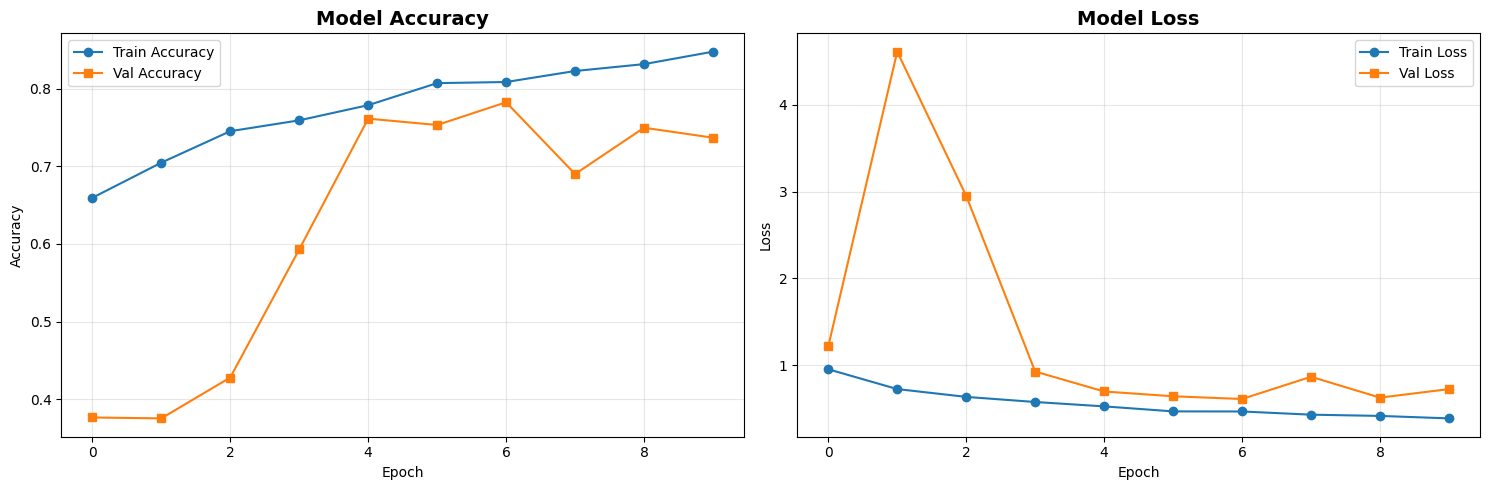

In [9]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
ax1.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy', marker='s')
ax1.set_title('Model Accuracy', fontsize=14, fontweight='bold')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot loss
ax2.plot(history.history['loss'], label='Train Loss', marker='o')
ax2.plot(history.history['val_loss'], label='Val Loss', marker='s')
ax2.set_title('Model Loss', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()

# Save figure
viz_path = os.path.join(VIZ_DIR, f"day4_01_training_history_{timestamp}.png")
plt.savefig(viz_path, dpi=300, bbox_inches='tight')
print(f"Training curves saved to: {viz_path}")

plt.show()

## 10. Quick Evaluation on Test Set

In [10]:
print("🔍 Evaluating on test set...\n")

# Evaluate on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n{'='*60}")
print(f"📊 Test Set Results:")
print(f"{'='*60}")
print(f"  Test Loss: {test_loss:.4f}")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'='*60}")

# Save test results
test_results = {
    'timestamp': timestamp,
    'test_loss': float(test_loss),
    'test_accuracy': float(test_accuracy),
    'test_samples': len(test_df),
    'model_path': model_path
}

test_results_path = os.path.join(HISTORY_DIR, f"test_results_{timestamp}.json")
with open(test_results_path, 'w') as f:
    json.dump(test_results, f, indent=2)

print(f"\nTest results saved to: {test_results_path}")

🔍 Evaluating on test set...

46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7683 - loss: 0.6506

📊 Test Set Results:
  Test Loss: 0.6506
  Test Accuracy: 0.7683 (76.83%)

Test results saved to: ../../outputs/training_history/test_results_20251024_195238.json


## 11. Summary and Next Steps

In [11]:
print("\n" + "="*70)
print("🎉 DAY 4.1 COMPLETE - TRAINING FINISHED!")
print("="*70)

print("\n📊 Final Results Summary:")
print(f"  Training Accuracy:   {history.history['accuracy'][-1]*100:.2f}%")
print(f"  Validation Accuracy: {history.history['val_accuracy'][-1]*100:.2f}%")
print(f"  Test Accuracy:       {test_accuracy*100:.2f}%")
print(f"  Epochs Trained:      {len(history.history['loss'])}")

print("\n📁 Files Created:")
print(f"  ✅ Best Model:        {model_path}")
print(f"  ✅ Training History:  {history_json}")
print(f"  ✅ Training CSV:      {history_csv}")
print(f"  ✅ Test Results:      {test_results_path}")
print(f"  ✅ Visualization:     {viz_path}")

print("\n🎯 Next Steps:")
print("  1. Run day4_02_model_evaluation.ipynb for detailed evaluation")
print("  2. Generate confusion matrix and classification report")
print("  3. Analyze misclassifications")
print("  4. Run day4_03_predictions_analysis.ipynb for prediction visualization")

print("\n💡 Interpretation:")
if test_accuracy >= 0.85:
    print("  🌟 Excellent! Your model performs very well (>85% accuracy)")
elif test_accuracy >= 0.75:
    print("  ✅ Good! Your model performs well (75-85% accuracy)")
elif test_accuracy >= 0.60:
    print("  ⚠️  Okay. Model works but could be improved (60-75% accuracy)")
else:
    print("  ❌ Model needs improvement (<60% accuracy)")
    print("     Consider: more epochs, different architecture, or hyperparameter tuning")

print("\n" + "="*70)


🎉 DAY 4.1 COMPLETE - TRAINING FINISHED!

📊 Final Results Summary:
  Training Accuracy:   84.76%
  Validation Accuracy: 73.68%
  Test Accuracy:       76.83%
  Epochs Trained:      10

📁 Files Created:
  ✅ Best Model:        ../../outputs/models/best_model_20251024_195238.keras
  ✅ Training History:  ../../outputs/training_history/training_history_20251024_195238.json
  ✅ Training CSV:      ../../outputs/training_history/training_history_20251024_195238.csv
  ✅ Test Results:      ../../outputs/training_history/test_results_20251024_195238.json
  ✅ Visualization:     ../../outputs/visualizations/day4_01_training_history_20251024_195238.png

🎯 Next Steps:
  1. Run day4_02_model_evaluation.ipynb for detailed evaluation
  2. Generate confusion matrix and classification report
  3. Analyze misclassifications
  4. Run day4_03_predictions_analysis.ipynb for prediction visualization

💡 Interpretation:
  ✅ Good! Your model performs well (75-85% accuracy)

